# 1.Create mini CIFAR-10 

Re-use the code from the deep learning notebook to load the CIFAR-10 training and test datasets. 
Create a mini CIFAR-10 dataset with 5000 instances for training and 5000 instances for testing. 
The examples in CIFAR-10 are randomly shuffled so you can simply take the first 5000 examples of each dataset. Print the shape of the resulting training set and test set. 



In [3]:
# Your code goes here 

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 32
subset_size = 5000 


trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset_full = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


trainset_mini = Subset(trainset_full, range(subset_size))
testset_mini = Subset(testset_full, range(subset_size))


trainloader_mini = torch.utils.data.DataLoader(trainset_mini, batch_size=batch_size, shuffle=True, num_workers=4)
testloader_mini = torch.utils.data.DataLoader(testset_mini, batch_size=batch_size, shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


print("Mini Training Set:")
for images, _ in trainloader_mini:
    print(f"Batch shape: {images.size()}")
    break  

print("\nMini Test Set:")
for images, _ in testloader_mini:
    print(f"Batch shape: {images.size()}")
    break  

Files already downloaded and verified
Files already downloaded and verified
Mini Training Set:
Batch shape: torch.Size([32, 3, 32, 32])

Mini Test Set:
Batch shape: torch.Size([32, 3, 32, 32])


# 2.SVM  

Train a SVM classifier on PCA dimensionality reduced Histogram of Oriented Gradients features. You can re-use the code from the deep learning notebook but instead of using the full training and testing sets use the mini-CIFAR-10 datset you created in question 1. Report the classification accuracy and confusion matrix. 



In [4]:

# Your code goes here 
from skimage import feature
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

def extract_hog_features(data_loader):
    hog_features = []
    labels = []
    for images, targets in data_loader:
        for img in images:
            img = img.numpy().transpose((1, 2, 0))
            hog_feat = feature.hog(img, pixels_per_cell=(2, 2), cells_per_block=(2, 2), channel_axis=-1)
            hog_features.append(hog_feat)
        labels.extend(targets.numpy())
    return np.array(hog_features), np.array(labels)


train_features, train_labels = extract_hog_features(trainloader_mini)
test_features, test_labels = extract_hog_features(testloader_mini)

pca = PCA(n_components=0.95)  
train_features_pca = pca.fit_transform(train_features)
test_features_pca = pca.transform(test_features)

clf = svm.SVC()
clf.fit(train_features_pca, train_labels)

svm_predictions = clf.predict(test_features_pca)
svm_accuracy = accuracy_score(test_labels, svm_predictions)
svm_conf_matrix = confusion_matrix(test_labels, svm_predictions)


print("Classification Accuracy:", svm_accuracy)
print("Confusion Matrix:\n", svm_conf_matrix)
 

Classification Accuracy: 0.4662
Confusion Matrix:
 [[177  16  40  14  69   4  37  13 107  11]
 [ 21 323   3   2  20   2  33   2  71  28]
 [ 28   7 111  40  96  75  88  19  34  14]
 [ 13  12  31 128  61  70 106  34  18  24]
 [ 12  10  24  30 271  29  68  28  27   8]
 [  4   1  27  65  58 174 100  34  11  14]
 [  6  15  18  21  37  21 350   7  12   4]
 [ 10   4  36  26  77  40  26 229  25  22]
 [ 52  35  10   8  23   5  31  12 305  23]
 [ 20  32  13  19  39  13  16  17  81 263]]


#  3.Gaussian Naive Bayes Classifier 

Repeat the training and evaluation of the mini-CIFAR-10 dataset using the Gaussian Naive Bayes 
classifier from scikit-learn: [Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
Similarly report on the classification accuracy and confusion matrix. 

In [5]:
# YOUR CODE GOES HERE 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix




gnb = GaussianNB()

gnb.fit(train_features_pca, train_labels)

gnb_predictions = gnb.predict(test_features_pca)

gnb_accuracy = accuracy_score(test_labels, gnb_predictions)
gnb_conf_matrix = confusion_matrix(test_labels, gnb_predictions)

print("Classification Accuracy:", gnb_accuracy)
print("Confusion Matrix:\n", gnb_conf_matrix)

Classification Accuracy: 0.279
Confusion Matrix:
 [[193  10 108  12  35  21  32   5  64   8]
 [110 119  94  16  38   9  33   4  62  20]
 [ 91   3 201  24  48  52  60   7  16  10]
 [ 41   6 134  70  53  79  64  27   9  14]
 [ 41   5 112  14 122  41 135  19  14   4]
 [ 34   0 123  59  50 107  78  20  11   6]
 [ 29   2  95  18  55  39 234  12   2   5]
 [ 65   2 127  31  57  53  49  91   9  11]
 [160  16  76  16  29  21  20  11 145  10]
 [ 71  23  83  34  46  41  43  23  36 113]]


 # 4.Sort classes by prediction accuracy 
 
Write a function that takes as input the computed confusion matrix and returns a list of classes sorted by classification accuracy. Each item in the list should be a tuple of the form (class, accuracy). Show the outpput for the SVM and Gaussian NB classifiers for the mini CIFAR-10 dataset. 


In [7]:
# Your answer goes here
from tabulate import tabulate

def classes_sorted_by_accuracy(conf_matrix, class_names):
    class_accuracy = []
    for i, class_name in enumerate(class_names):
        accuracy = conf_matrix[i, i] / conf_matrix[i].sum()
        accuracy_rounded = round(accuracy, 4)
        class_accuracy.append((class_name, accuracy_rounded))
    
    class_accuracy.sort(key=lambda x: x[1], reverse=True)
    
    return class_accuracy


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


svm_sorted_accuracy = classes_sorted_by_accuracy(svm_conf_matrix, classes)
gnb_sorted_accuracy = classes_sorted_by_accuracy(gnb_conf_matrix, classes)

print("SVM Classifier Accuracy by Class:")
print(tabulate(svm_sorted_accuracy, headers=['Class', 'Accuracy'], tablefmt='orgtbl'))

print("\nGaussian Naive Bayes Classifier Accuracy by Class:")
print(tabulate(gnb_sorted_accuracy, headers=['Class', 'Accuracy'], tablefmt='orgtbl'))

SVM Classifier Accuracy by Class:
| Class   |   Accuracy |
|---------+------------|
| frog    |     0.7128 |
| car     |     0.6396 |
| ship    |     0.6052 |
| deer    |     0.5345 |
| truck   |     0.5127 |
| horse   |     0.4626 |
| plane   |     0.3627 |
| dog     |     0.3566 |
| cat     |     0.2575 |
| bird    |     0.2168 |

Gaussian Naive Bayes Classifier Accuracy by Class:
| Class   |   Accuracy |
|---------+------------|
| frog    |     0.4766 |
| plane   |     0.3955 |
| bird    |     0.3926 |
| ship    |     0.2877 |
| deer    |     0.2406 |
| car     |     0.2356 |
| truck   |     0.2203 |
| dog     |     0.2193 |
| horse   |     0.1838 |
| cat     |     0.1408 |


# 5.Show misclassification examples  

Write a function that takes as input a particular class (for example dog) and shows an array 
of images (similar to the functions showing images in the deep learning notebook) in which each row contains 10 example images from another class that were misclassified. The resulting grid will have 9 rows (one for each class other than the input class) and 10 examples. For example the row for truck would have images of trucks that were misclassified as dogs. Show the output of this function for the SVM classifier and the class horse. 





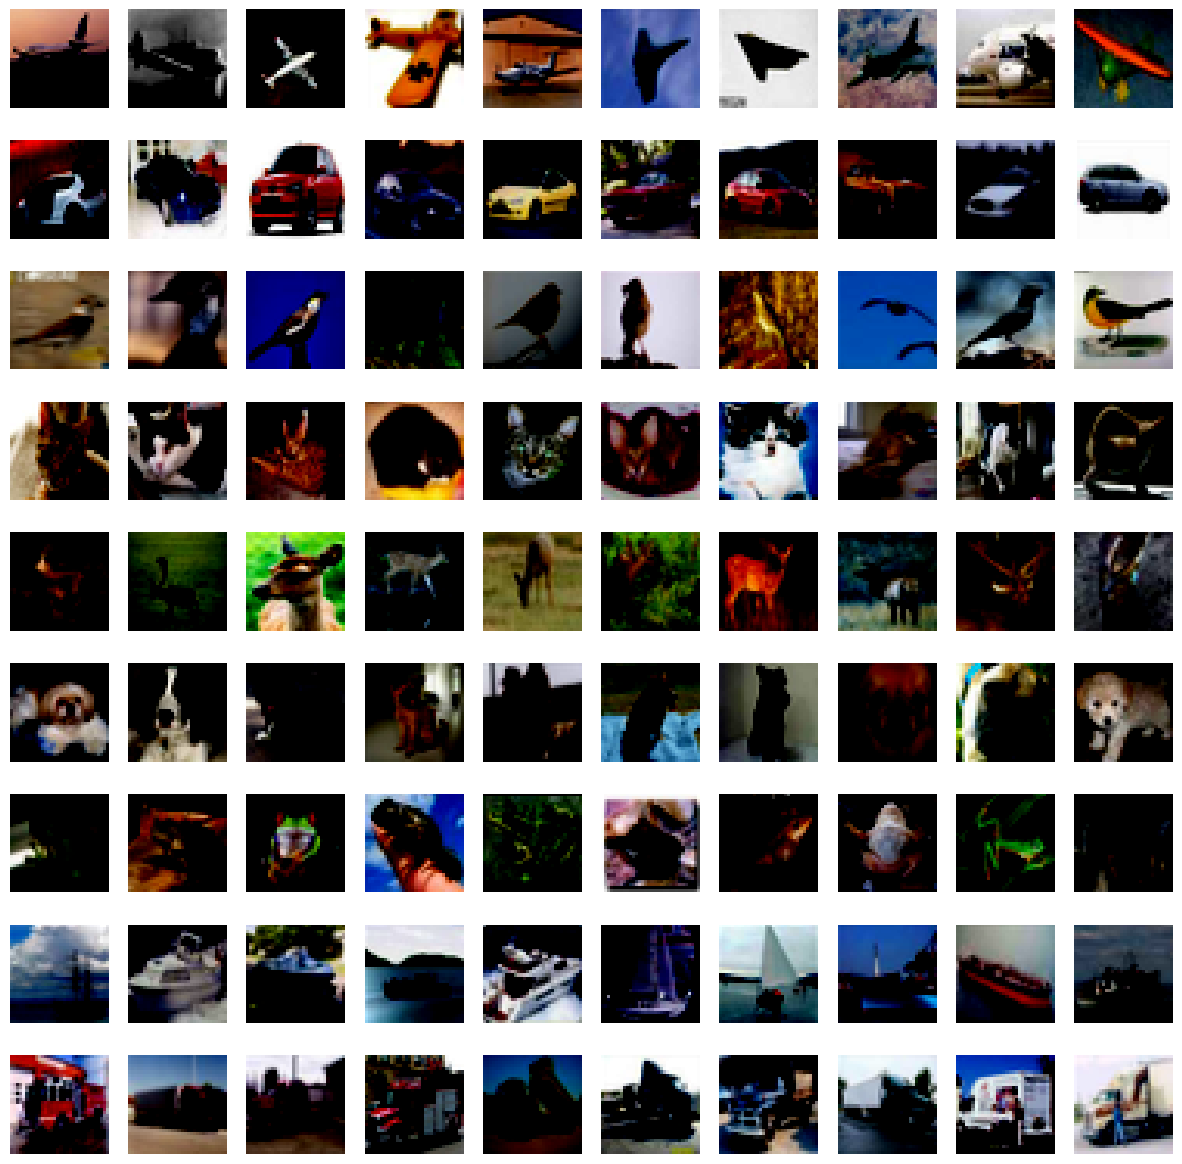

In [9]:
# Your answer goes here 
import matplotlib.pyplot as plt


def show_misclassified_images(test_loader, true_labels, pred_labels, class_names, target_class, num_examples=10):
    target_class_index = class_names.index(target_class)
    misclassified = {class_name: [] for class_name in class_names if class_name != target_class}

    for images, labels in test_loader:
        for image, true_label, pred_label in zip(images, labels, pred_labels):
            if true_label != target_class_index and pred_label == target_class_index:
            
                image_normalized = np.clip(image.numpy().transpose((1, 2, 0)), 0, 1)
                misclassified[class_names[true_label]].append(image_normalized)

    fig, axes = plt.subplots(nrows=len(misclassified), ncols=num_examples, figsize=(15, 15))
    for i, (class_name, imgs) in enumerate(misclassified.items()):
        for j in range(num_examples):
            if j < len(imgs):
                axes[i, j].imshow(imgs[j])
                axes[i, j].axis('off')
            else:
                axes[i, j].axis('off')
        axes[i, 0].set_ylabel(class_name)

    plt.show()

show_misclassified_images(testloader_mini, test_labels, svm_predictions, classes, 'horse')

# 6.Comparison of different features 

In the deep learning notebook the CIFAR-10 classification code using SVM utilizes a histogram of oriented gradients features followed by a PCA transformation for dimensionality reduction. 
Using the mini-CIFAR-10 dataset compare the following three feature front-ends using SVM classificaiton (use the same parameters as the deep learning notebook): 

1. Flatten the training images to a single (32 * 32 * 3) vector
2. Compute the Histogram of Gradients
3. Computer the Histogram of Gradients followed by PCA (as done in the deep learning notebook).

Compare these three feature front ends by showing the corresponding classification accurarcy and confusion matrices for each one. 


In [9]:
# Your code goes here 
def flatten_images(data_loader):
    flattened_features = []
    labels = []
    for images, targets in data_loader:
        flattened_features.extend(images.view(images.size(0), -1).numpy())
        labels.extend(targets.numpy())
    return np.array(flattened_features), np.array(labels)

def extract_hog_features(data_loader):
    hog_features = []
    labels = []
    for images, targets in data_loader:
        for img in images:
            img = img.numpy().transpose((1, 2, 0))  
            hog_feat = feature.hog(img, pixels_per_cell=(2, 2), cells_per_block=(2, 2), channel_axis=-1)
            hog_features.append(hog_feat)
        labels.extend(targets.numpy())
    return np.array(hog_features), np.array(labels)

train_features_flat, train_labels_flat = flatten_images(trainloader_mini)
test_features_flat, test_labels_flat = flatten_images(testloader_mini)


train_features_hog, train_labels_hog = extract_hog_features(trainloader_mini)
test_features_hog, test_labels_hog = extract_hog_features(testloader_mini)


pca = PCA(n_components=0.95)
train_features_pca = pca.fit_transform(train_features_hog)
test_features_pca = pca.transform(test_features_hog)


svm_flat = svm.SVC()
svm_flat.fit(train_features_flat, train_labels_flat)
flat_predictions = svm_flat.predict(test_features_flat)
accuracy_flat = accuracy_score(test_labels_flat, flat_predictions)
conf_matrix_flat = confusion_matrix(test_labels_flat, flat_predictions)


svm_hog = svm.SVC()
svm_hog.fit(train_features_hog, train_labels_hog)
hog_predictions = svm_hog.predict(test_features_hog)
accuracy_hog = accuracy_score(test_labels_hog, hog_predictions)
conf_matrix_hog = confusion_matrix(test_labels_hog, hog_predictions)


svm_pca = svm.SVC()
svm_pca.fit(train_features_pca, train_labels_hog)
pca_predictions = svm_pca.predict(test_features_pca)
accuracy_pca = accuracy_score(test_labels_hog, pca_predictions)
conf_matrix_pca = confusion_matrix(test_labels_hog, pca_predictions)

print("SVM with Flattened Images:")
print("Accuracy:", accuracy_flat)
print("Confusion Matrix:\n", conf_matrix_flat)

print("\nSVM with HOG Features:")
print("Accuracy:", accuracy_hog)
print("Confusion Matrix:\n", conf_matrix_hog)

print("\nSVM with HOG Features + PCA:")
print("Accuracy:", accuracy_pca)
print("Confusion Matrix:\n", conf_matrix_pca)

SVM with Flattened Images:
Accuracy: 0.453
Confusion Matrix:
 [[261  15  26   8  18   7  15  17  93  28]
 [ 22 257  16  19   9  20  24  11  38  89]
 [ 55   7 166  30  89  29  73  31  20  12]
 [ 20  15  38 116  44 107  66  38  16  37]
 [ 26   9  88  14 207  26  73  32  20  12]
 [ 17  13  54  82  40 165  55  27  17  18]
 [ 10   8  45  27  72  28 258  12  12  19]
 [ 29  19  33  24  56  44  24 209  21  36]
 [ 43  27   8   5  12  13   4  10 348  34]
 [ 26  58   7  19   9  13  19  26  58 278]]

SVM with HOG Features:
Accuracy: 0.4736
Confusion Matrix:
 [[213  16  51  28  44   7  23  12  86   8]
 [ 27 326   3   6  16   2  28   1  68  28]
 [ 37   7 137  54  67  79  60  23  34  14]
 [ 14  11  36 158  50  78  76  34  15  25]
 [ 19  10  38  47 236  35  54  31  28   9]
 [  4   1  41  78  36 192  70  39  13  14]
 [ 10  18  29  41  33  32 306   7  10   5]
 [ 20   3  46  38  53  46  14 236  20  19]
 [ 67  35  12   9  15   6  29  12 294  25]
 [ 29  34  17  27  24  14   8  17  73 270]]

SVM with HOG Fe

# 7.Deep learning classification  

Retrain the deep neural network specified in the deep learning notebook. You will need to install PyTorch for your system. You don't need to use the GPU unless you have one and can set it up. 
Your training time will depend on your hardware on my laptop with CPU it takes about 4 minutes and with GPU about 2 minutes. It should not be more than 30 minutes even on an old slow laptop. Another option is to use Google Colab. 

Once you have trained and evaluated the network and got numbers similar to the deep learning notebook change the batch size to 16. Repeat the training and report on how the accuracy and training time changed. 



In [27]:
# Your code goes here
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


def train_and_evaluate(batch_size):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
    start_time = time.time()
    for epoch in range(2):  
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()


        avg_loss = running_loss / len(trainloader)
        print(f'Epoch {epoch+1}, Average Loss: {avg_loss:.4f}')

        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}, Accuracy: {accuracy}%')

    training_time = time.time() - start_time
    return training_time, accuracy

initial_batch_size = 32
time_initial, accuracy_initial = train_and_evaluate(initial_batch_size)

batch_size_16 = 16
time_16, accuracy_16 = train_and_evaluate(batch_size_16)


print(f'Initial batch size ({initial_batch_size}): Training time = {time_initial:.2f} seconds, Accuracy = {accuracy_initial}%')
print(f'Batch size 16: Training time = {time_16:.2f} seconds, Accuracy = {accuracy_16}%') 

Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Average Loss: 2.1107
Epoch 1, Accuracy: 33.97%
Epoch 2, Average Loss: 1.6499
Epoch 2, Accuracy: 43.73%
Epoch 1, Average Loss: 1.4362
Epoch 1, Accuracy: 52.85%
Epoch 2, Average Loss: 1.2405
Epoch 2, Accuracy: 58.56%
Initial batch size (32): Training time = 49.18 seconds, Accuracy = 43.73%
Batch size 16: Training time = 57.42 seconds, Accuracy = 58.56%


# 8.Deep learning classification of noisy images

In this question you will explore the effect of adding noise to the classification of the CIFAR-10 dataset. You can add random noise with a mean of 0 and standard deviation of 1 to a tensor using the *torch.randn*. For example: x = x + torch.randn(x.shape) will add noise to the tensor x. 
Add noise with a mean of 0 and a standard deviation of 0.2 to the images of the CIFAR-10 dataset. First see how the images with the added noise will look by adding the noise in the *imshow* function. Then check how the classification accuracy on the test set is affected if you add noise to the test but NOT the training set. 


Files already downloaded and verified
Files already downloaded and verified
Original Images


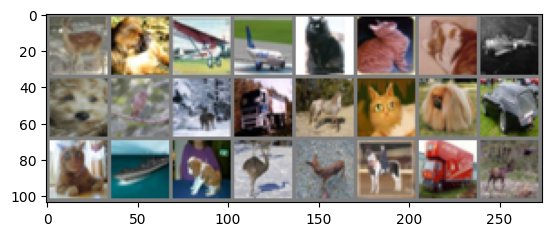

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Noisy Images


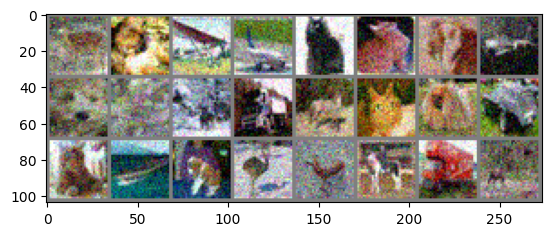

NameError: name 'Net' is not defined

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


num_batches_to_show = 6  
dataiter = iter(trainloader)
all_original_images = []
all_noisy_images = []

for _ in range(num_batches_to_show):
    images, labels = next(dataiter)
    all_original_images.append(images)


    noise = torch.randn(images.shape) * 0.2
    noisy_images = images + noise
    all_noisy_images.append(noisy_images)

original_images_grid = torchvision.utils.make_grid(torch.cat(all_original_images, dim=0))
noisy_images_grid = torchvision.utils.make_grid(torch.cat(all_noisy_images, dim=0))


print("Original Images")
imshow(original_images_grid)


print("Noisy Images")
imshow(noisy_images_grid)


net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


for epoch in range(3):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0


print('Finished Training')


def test_with_noise(net, data_loader, noise_std=0.2):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            noise = torch.randn_like(images) * noise_std
            noisy_images = images + noise
            outputs = net(noisy_images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

accuracy_noisy = test_with_noise(net, testloader)
print(f'Accuracy on noisy test set: {accuracy_noisy}%')